In [ ]:
#This notebook is not working

This project is to replicate an internal RAG-building effort at
Aware, a Columbus software startup that uses AI in the digital workplace to help
customers reduce operational costs and drive insights from their internal data
(such as those derived from HR surveys, Slack conversations, or email). The
teams will be provided with more than 5 million public Reddit submissions and
comments. The objective will be to build a system that can, given a user's
query, identify and rank the most relevant content in these messages. As Aware
deals with large, heterogeneous data sets, two key priorities for their teams
emerge: (1) the system must be fast (sub-second response is a requirement),
and (2) there needs to be some way to measure the qualitative performance of
the result sets across retrieval methods

To get started:
start exploring vector databases (open source or free). 
I recommend LanceDB, PGVector, Redis, sqlite-vss

RAG Flow Chart


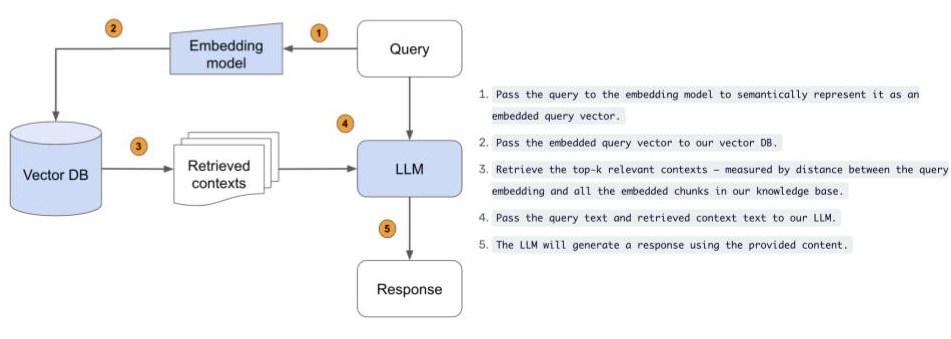

In [1]:
from IPython.display import Image

print("RAG Flow Chart")
display(Image(filename='../figures/RAG_flow.png', width=900))

In [2]:
#installation and import statements
from __future__ import annotations
import numpy as np
import time
import lancedb # our vector database
from lancedb.embeddings import get_registry #embedding registry
from lancedb.pydantic import LanceModel, Vector, pydantic_to_schema
from lancedb.embeddings import TextEmbeddingFunction
from datasets import load_dataset
import pandas as pd
import pyarrow as pa
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from datasets import load_dataset



# Get Dataset

In [3]:
dataset = load_dataset("roneneldan/TinyStories", data_files={'train': 'TinyStoriesV2-GPT4-train.txt'})
dataset["train"]['text'][0:10]

Repo card metadata block was not found. Setting CardData to empty.


['',
 'Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  ',
 'He said, “Wow, that is a really amazing vase! Can I buy it?” ',
 'The shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”',
 "So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. ",
 "And that's how Ben found an amazing vase in the store!",
 '<|endoftext|>',
 'Once upon a time, there was a reliable otter named Ollie. He lived in a river with his family. They all loved to play and swim together.',
 'One day, Ollie\'s mom said, "Ollie, hurry and get some fish for dinner!" Ollie swam

In [4]:
# Create pandas data frame from Dataset and add ID column
import pandas as pd

df = pd.DataFrame(dataset["train"][1:1001])
df['id'] = np.arange(len(df))

In [5]:
df[0:10]

,text,id
0,Once upon a time there was a little boy named ...,0
1,"He said, “Wow, that is a really amazing vase! ...",1
2,"The shopkeeper smiled and said, “Of course you...",2
3,So Ben took the vase home and he was so proud ...,3
4,And that's how Ben found an amazing vase in th...,4
5,<|endoftext|>,5
6,"Once upon a time, there was a reliable otter n...",6
7,"One day, Ollie's mom said, ""Ollie, hurry and g...",7
8,"While Ollie was catching fish, he found a big ...",8
9,<|endoftext|>,9


# Connect to LanceDB and create table

In [6]:
db = lancedb.connect("~/.lancedb")

table = db.create_table("tiny_stories", df, mode="overwrite")


# Embeddings
1) Define the embedding function
2) Define the embedding model or schema
3) Create table and add data
4) Query table

## Define the embedding function

In [7]:
model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
vectors = model.encode(df.text.values.tolist(),
                       convert_to_numpy=True,
                       normalize_embeddings=True).tolist()

In [8]:
vectors[0][0:10]

[-0.048345670104026794,
 0.11281958222389221,
 0.03041011467576027,
 -0.0006237158086150885,
 0.02209452912211418,
 -0.017141833901405334,
 0.1429537981748581,
 -0.007708535995334387,
 -0.0013059168122708797,
 -0.015852684155106544]

### Save embedding vectors to table

In [9]:
from lance.vector import vec_to_table
import numpy as np
import pyarrow as pa

embeddings = vec_to_table(vectors)
embeddings = embeddings.append_column("id", pa.array(np.arange(len(table))+1))
embeddings.to_pandas().head()

,vector,id
0,"[-0.04834567, 0.11281958, 0.030410115, -0.0006...",1
1,"[-0.038759846, 0.1088848, 0.046834134, -0.0461...",2
2,"[-0.023753466, 0.1392002, -0.0019640187, -0.01...",3
3,"[0.056042682, 0.1493148, 0.07396823, -0.054801...",4
4,"[0.0062744906, 0.0939931, 0.06361841, -0.03023...",5


In [10]:
table.merge(embeddings, left_on="id")
table.head().to_pandas()

,text,id,vector
0,Once upon a time there was a little boy named ...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"He said, “Wow, that is a really amazing vase! ...",1,"[-0.04834567, 0.11281958, 0.030410115, -0.0006..."
2,"The shopkeeper smiled and said, “Of course you...",2,"[-0.038759846, 0.1088848, 0.046834134, -0.0461..."
3,So Ben took the vase home and he was so proud ...,3,"[-0.023753466, 0.1392002, -0.0019640187, -0.01..."
4,And that's how Ben found an amazing vase in th...,4,"[0.056042682, 0.1493148, 0.07396823, -0.054801..."


In [11]:
table

LanceTable(connection=LanceDBConnection(/Users/nessmaykerchen/.lancedb), name="tiny_stories")

## Build Approximate Nearest Neighbors Index

In [12]:
# !pip install tantivy

# table.create_fts_index("text")
table.create_index(
     num_partitions=25, #6
     num_sub_vectors=9, #6
     accelerator="mps"
)    


 30%|████████████▉                              | 15/50 [00:00<00:00, 51.05it/s]


0it [00:00, ?it/s]

/Users/nessmaykerchen/anaconda3/lib/python3.11/site-packages/lance/torch/data.py:67: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  tensor = torch.from_numpy(arr.to_numpy(zero_copy_only=False))
[2024-03-03T19:04:16Z WARN  lance_linalg::kmeans] KMeans: more than 10% of clusters are empty: 56 of 256.
    Help: this could mean your dataset is too small to have a meaningful index (less than 5000 vectors) or has many duplicate vectors.
[2024-03-03T19:04:16Z WARN  lance_linalg::kmeans] KMeans: more than 10% of clusters are empty: 55 of 256.
    Help: this could 

## Embed the Query

In [13]:
query = model.encode("Sophia sit bench",
                       convert_to_numpy=True,
                       normalize_embeddings=True).tolist()
print(query[0:10])


[-0.026922283694148064, -0.05654112249612808, 0.0014822668163105845, -0.03936275467276573, -0.04618893936276436, 0.06736499071121216, 0.041890714317560196, 0.043769098818302155, 0.003918011207133532, 0.02523164451122284]


## Search for Approximate Nearest Neighbors
By default, LanceDB runs a brute-force scan over dataset to find the K nearest neighbours (KNN). For tables with more than 50K vectors, creating an ANN index is recommended to speed up search performance.

Using an ANN index is faster, but less accurate than kNN or brute force search because, in essence, the index is a lossy representation of the data.

In [14]:
table.search(query) \
    .limit(4) \
    .nprobes(20) \
    .refine_factor(10) \
    .to_pandas()

,text,id,vector,_distance
0,Suddenly a butterfly came flying in front of h...,875,"[0.0076351324, 0.059342176, 0.047681164, 0.073...",0.917648
1,Once upon a time there was a little boy named ...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000
2,Sophia sat down on a bench and settled her bag...,874,"[0.0072682137, 0.0490797, 0.051354233, 0.06685...",1.098002
3,"Sophia looked at her bag in surprise, but she ...",877,"[0.0073507833, 0.034702606, 0.051570863, 0.077...",1.265759


In [15]:
panda = table.search(query) \
    .limit(4) \
    .nprobes(20) \
    .refine_factor(10) \
    .to_pandas()

In [17]:
panda.text

0    Suddenly a butterfly came flying in front of h...
1    Once upon a time there was a little boy named ...
2    Sophia sat down on a bench and settled her bag...
3    Sophia looked at her bag in surprise, but she ...
Name: text, dtype: object

In [18]:
from transformers import AutoTokenizer, pipeline
import transformers
import torch

In [19]:
from llama_cpp import Llama

llm = Llama(
      model_path="../llama/llama-2-7b/llama-2-7b.Q5_K_M.gguf",
#       model_path="../llama/llama-2-7b/llama-2-7b.Q2_K.gguf",
    # n_gpu_layers=-1, # Uncomment to use GPU acceleration
      # seed=1337, # Uncomment to set a specific seed
      # n_ctx=2048, # Uncomment to increase the context window
)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../llama/llama-2-7b/llama-2-7b.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_count u32 

In [24]:
output = llm(
      panda.vector, # Prompt
      max_tokens=None, # Generate up to 32 tokens, set to None to generate up to the end of the context window
      stop=["Q:", "\n"], # Stop generating just before the model would generate a new question
      echo=True # Echo the prompt back in the output
) # Generate a completion, can also call create_completion
print(output['choices'])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()